# Performing a PCA analysis on our protein fragment. 
Our goal is to use PCA to identify the major structural changes occurring in our protein fragment which contains both an ordered and disordered component. In this notebook we should keep in mind the assumptions associated with the choice of the *feature* used to perform the PCA and how that influences our interpretation!

In [1]:
# for calculating the pairwise distances between our atoms from our molecular dynamics simulations 
import MDAnalysis as mda
from MDAnalysis.analysis import distances

# for performing PCA using scikit-learn
from sklearn.decomposition import PCA
from sklearn import preprocessing

# for math, plotting, and general utilities
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for prettier images.
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

C:\Users\wular\anaconda3\envs\inspire_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### We must first compute the feature vectors for each time step in our trajectory.
Our feature vector contains the pairwise distances between all alpha-carbons (green atoms) of our structures. The figure shown here illustrates what we mean by 'pairwise distances between alpha-carbons'. Only a few of the total pairwise distances are shown.

<div style="text-align: center;">
  <img src="pics/h4_pwdists_rendering.png" alt="Representation of pairwise distance between a few of the alpha-carbon." style="width:60%;">
</div>

In [4]:
# set the universe
uni        = mda.Universe('./data/h4_fragment/H4_FRAGMENT.pdb', './data/ALIGNED_400K.xtc') # a topology (.pdb) and a trajectory (.xtc) are required
n_residues = uni.select_atoms('name CA').residues.n_residues # extract the total number of residues in our structure
print(n_residues)

# calculate the pairwise distances between all alpha-carbons, for EACH timestep in our trajectory.
pwdists_array = [] # empty list that will store the vector of pairwise distances for each timestep
for ts in tqdm(uni.trajectory):
    dists = distances.self_distance_array(uni.select_atoms('name CA').positions) # compute pwise distances
    pwdists_array.append(dists) # append the distances to our empty list

# we can check what the final dimension of our array of pairwise distances is
print(np.asarray(pwdists_array).shape)

20


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1952.44it/s]

(5000, 190)


### We can now perform the principal component analysis.
- We make use of the sci-kit learn library in python that already has the functions to perform the PCA. Let's walk through the steps that we need to perform that are very similar to the previous, simple, example that we performed.
- Ask yourself: what are the features (variables) and what are the samples? Can you identify if the features (variables) are the rows or the columns of your array?

In [6]:
# make into a dataframe and then get the values of the data frame.
# each column is a residue position, each row is a unique structure 
df      = pd.DataFrame(pwdists_array)
pwdists = df.values

# scale the data to have mean = 0 and std = 1
scaler               = preprocessing.StandardScaler()
pwdists_standardized = scaler.fit_transform(pwdists)

## next we create the PCA object that will perform the transformation of our data

# set number of PCs to keep
nPcs               = 10

# create the PCA object
PCA                = PCA(n_components=nPcs)

# project the original data onto our new principal component basis
Projections        = PCA.fit_transform(pwdists_standardized)

# extract the amount of variance that is explained by each principal component
explained_per_var  = np.round(PCA.explained_variance_ratio_*100,)

# Plot the percent variance that is captured by each principal component.
- Notice how the percent variance captured by each PC quickly tails off. This is a good indication that the first 2 PCs are sufficient to describe our original data in our new basis, without compromising the original data.

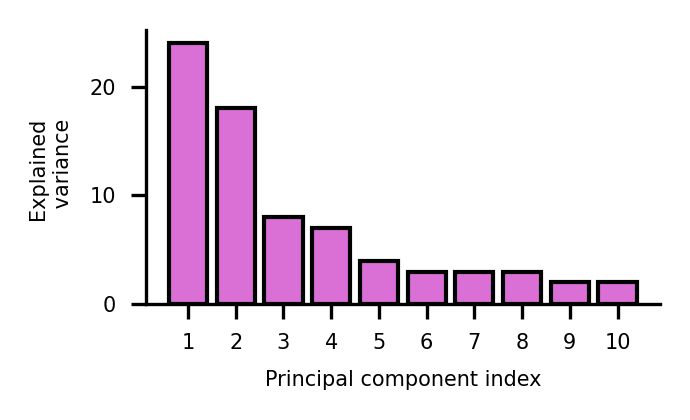

In [7]:
plt.figure(dpi=300, figsize=(2.4, 1.5))

plt.bar(x=range(10), height=explained_per_var, color='orchid', edgecolor='k', lw=1)
plt.xticks(range(0, 10, 1), range(1, 11, 1), fontsize=5)
plt.yticks(fontsize=5)

plt.xlabel('Principal component index', fontsize=5)
plt.ylabel('Explained \n variance', fontsize=5)

plt.tight_layout()
plt.show()

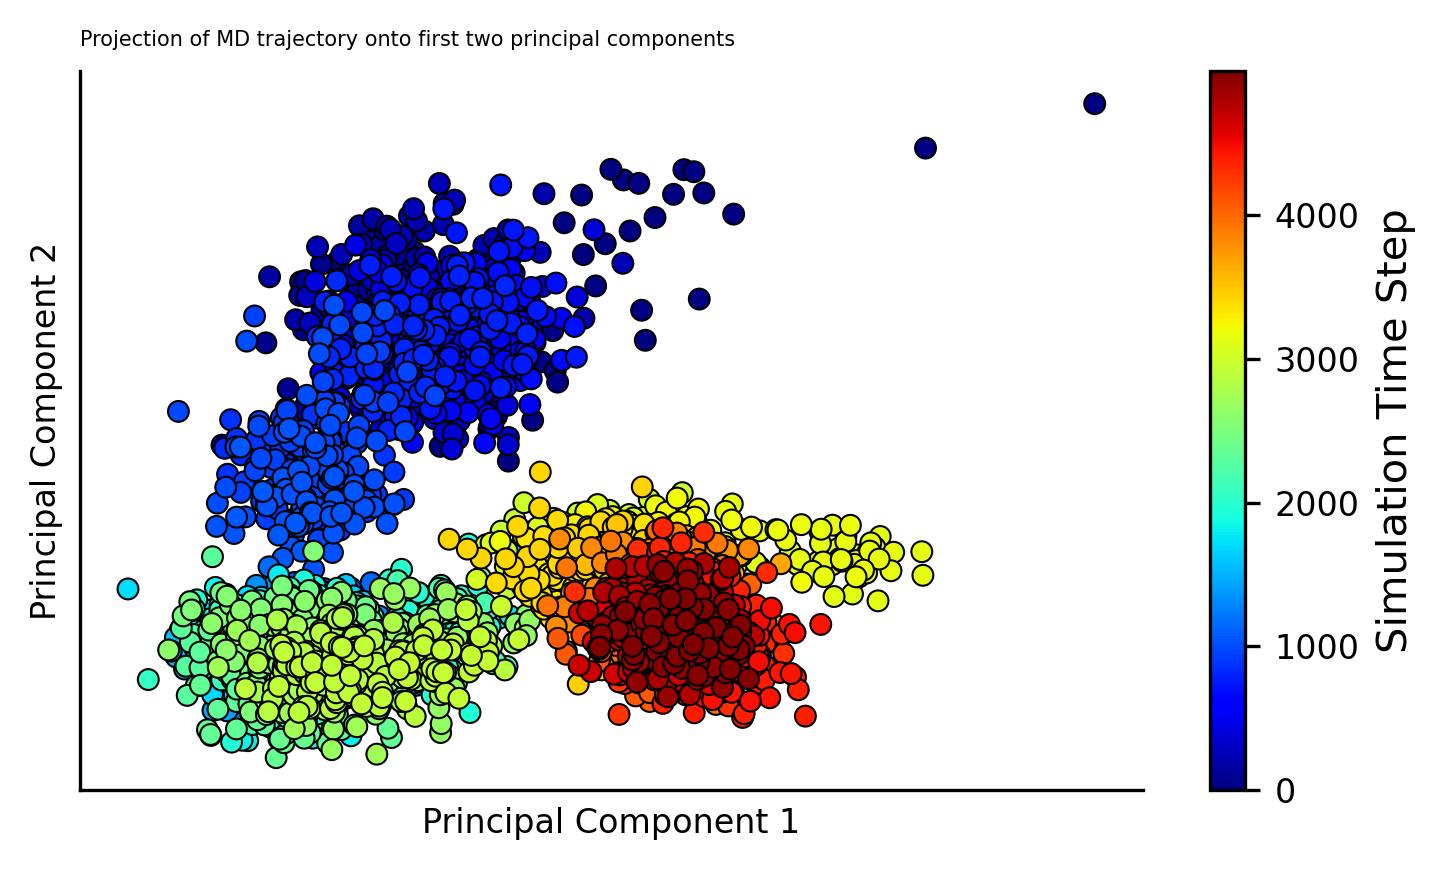

In [8]:
# set up the figure dimensions and resolution
plt.figure(dpi=300, figsize=(5, 3))

# to color each point by its time-point, we create an array corresponding to each timepoint
color_times = np.arange(Projections[:, 0].shape[0])

plt.title('Projection of MD trajectory onto first two principal components', loc='left', fontsize=5)
pc1_data = Projections[:, 0]
pc2_data = Projections[:, 1]

# plot as a scatter plot, using our coloring to see which scatter points correspond to which timepoints
plt.scatter(pc1_data, pc2_data, edgecolor='k', lw=0.5, s=25, c=color_times, cmap='jet')

# labels and other figure options
plt.xlabel('Principal Component 1', fontsize=8)
plt.ylabel('Principal Component 2', fontsize=8)
cbar = plt.colorbar(label='Simulation Time Step')
cbar.ax.tick_params(labelsize=8) 
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

### How can we interpret PC1? What does it physically correspond to regarding the protein structure?
- Remember that the PCs are a linear combination of the original data -- the original data were pairwise distances between alpha carbon atoms.
- PC1 is a linear combinaton of the pairwise distances. We can see which pairwise distances contribute the most to PC1 by looking at a heat map.
- Similar to the MNIST data set, we want to return our flattened vector of pairwise distances back into a matrix representation, for much easier interpretation!

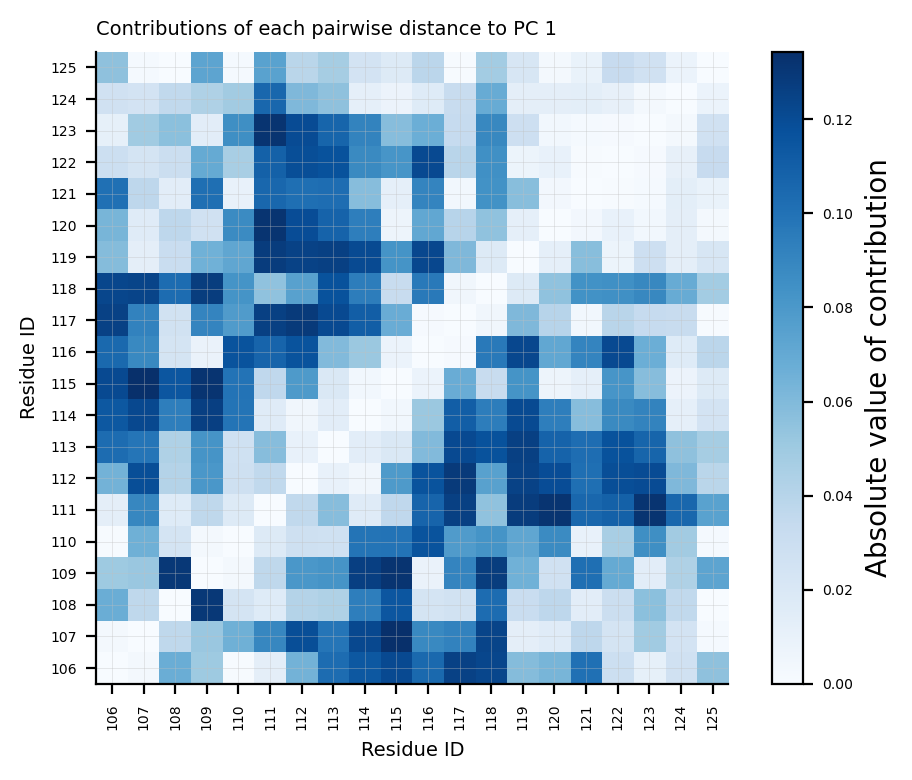

In [11]:
contributions = pd.DataFrame(PCA.components_.T, columns = np.array(list(f'PC {i}' for i in range(1, 11, 1))))

# we want to reshape our vector into an array with dimensions of n_residues x n_residues
# that will present us with a map of the pairwise distances (i.e. the original data) and their contributions to PC1
pc1_values         = contributions.values.T[0]
n_residues         = n_residues
pc1_heatmap        = np.zeros((n_residues, n_residues))
triu               = np.triu_indices(n_residues, 1) ## ofset by 1 to get upper-triangular portion
pc1_heatmap [triu] = pc1_values

plt.figure(dpi=200, figsize=(5,4))
plt.grid(axis='both', color='silver', zorder=101, lw=0.25, ls = '-', alpha=0.5)
plt.imshow(np.abs(pc1_heatmap + pc1_heatmap.T), origin='lower', cmap='Blues')

residues = uni.select_atoms('name CA').residues.resids
plt.xticks(range(len(residues))[::], residues[::], fontsize=5, rotation=90)
plt.yticks(range(len(residues))[::], residues[::], fontsize=5)
plt.xlabel('Residue ID', fontsize=7)
plt.ylabel('Residue ID', fontsize=7)
plt.title('Contributions of each pairwise distance to PC 1', fontsize=7, loc='left')
cbar = plt.colorbar(label = 'Absolute value of contribution')
cbar.ax.tick_params(labelsize=5) 
plt.tight_layout()
plt.show()

### Your turn: We may also consider what combination of distances contributes to the second principal component
- Create a heatmap of the pairwise distances representing their contributions to PC2.
- Describe the physical interpretation of PC2 (hint: consider the scatter points that are colored in time and relate this back to the structres you observe in the trajectory in ChimeraX)

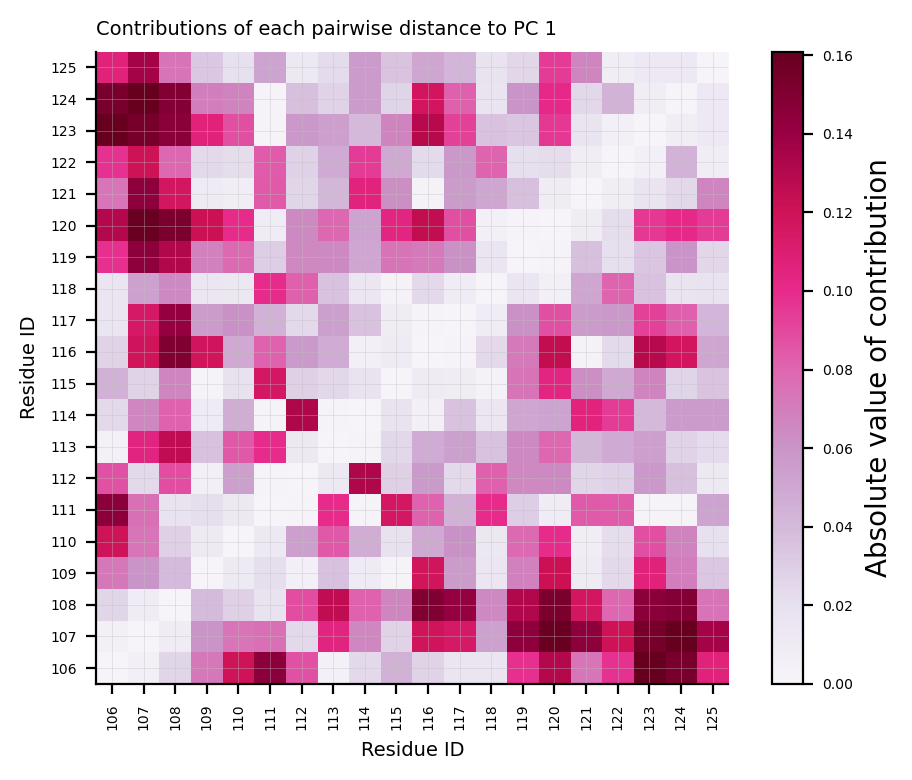

In [18]:
contributions = pd.DataFrame(PCA.components_.T, columns = np.array(list(f'PC {i}' for i in range(1, 11, 1))))

# we want to reshape our vector into an array with dimensions of n_residues x n_residues
# that will present us with a map of the pairwise distances (i.e. the original data) and their contributions to PC1
pc1_values         = contributions.values.T[1]
n_residues         = n_residues
pc1_heatmap        = np.zeros((n_residues, n_residues))
triu               = np.triu_indices(n_residues, 1) ## ofset by 1 to get upper-triangular portion
pc1_heatmap [triu] = pc1_values

plt.figure(dpi=200, figsize=(5,4))
plt.grid(axis='both', color='silver', zorder=101, lw=0.25, ls = '-', alpha=0.5)
plt.imshow(np.abs(pc1_heatmap + pc1_heatmap.T), origin='lower', cmap='PuRd')

residues = uni.select_atoms('name CA').residues.resids
plt.xticks(range(len(residues))[::], residues[::], fontsize=5, rotation=90)
plt.yticks(range(len(residues))[::], residues[::], fontsize=5)
plt.xlabel('Residue ID', fontsize=7)
plt.ylabel('Residue ID', fontsize=7)
plt.title('Contributions of each pairwise distance to PC 1', fontsize=7, loc='left')
cbar = plt.colorbar(label = 'Absolute value of contribution')
cbar.ax.tick_params(labelsize=5) 
plt.tight_layout()
plt.show()